In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

## Installations and imports

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [3]:
import math
import os
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight


from utils import util_data, util_models, util_plot

kaggle.json not found, you cannot use kaggle module.


In [4]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

## Load the dataset

Laod the processed dataset from the repository.

In [5]:
df_train = pd.read_csv("data/model/gsm_train_std.csv")
df_test = pd.read_csv("data/model/gsm_test_std.csv")

df_train.head(3)

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,2.0,1.671445,1.499773,0.802435,1.545659,2.463256,3.151630,1,1,0,0,1,1,0,0,1.0,2.0,0.0,3.0
1,0.0,-0.101516,-0.728523,-0.400932,-0.568416,-0.218609,-0.051596,1,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
2,1.0,1.420276,2.068216,0.200752,1.545659,0.011265,1.016146,0,1,0,1,1,0,0,0,1.0,2.0,0.0,2.0


The dataset doesn't contain duplicates, and it is already preprocessed.

In [6]:
# Show duplicated rows
def get_dup_rows(df, drop_cols):
    dup_rows = df[df.duplicated(subset=df.columns.drop(drop_cols), keep=False)]
    return dup_rows

get_dup_rows(df_train, ["misc_price"])

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution


The dataset doesn't contain null values. The total number of rows is n (TODO: write at the end of the work), splitted in training and test datasets.

In [7]:
print(f"Null values:{df_train.isna().sum().sum()}")
print(f"Number of duplicated rows: {df_train.duplicated().sum()}")
print(f"Number of rows: {df_train.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1755


In [8]:
util_data.count_frequency_labels(df_train.misc_price).sort_index()

,Frequency,Count
0.0,35.95%,631
1.0,46.44%,815
2.0,17.61%,309


### Train, validation, test split for the model

In [9]:
print(f"Train dataset: {df_train.shape}, Test dataset: {df_test.shape}")

Train dataset: (1755, 19), Test dataset: (440, 19)


In [10]:
X_train_val, y_train_val = df_train.drop("misc_price", axis=1), df_train.misc_price
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

print(f"X_train_val: {X_train_val.shape}, y_train_val: {y_train_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_val: (1755, 18), y_train_val: (1755,)
X_test: (440, 18), y_test: (440,)


In [11]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=rng)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (1404, 18), y_train: (1404,)
X_val: (351, 18), y_val: (351,)


## Models

### Neural network

In [12]:
import torch
from torch.utils.data import DataLoader
import torchsummary

In [38]:
EPOCHS = 100
BATCH_SIZE = 512
LR = 0.01
N_SPLITS = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))
hidden_layers = [128, 128]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class).to(device)
torchsummary.summary(nn_model, (BATCH_SIZE, num_features));

Device: cpu
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512, 128]            2,432
├─ReLU: 1-2                              [-1, 512, 128]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 512, 128]            16,512
├─ReLU: 1-3                              [-1, 512, 128]            --
├─Linear: 1-4                            [-1, 512, 3]              387
Total params: 19,331
Trainable params: 19,331
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.04
Forward/backward pass size (MB): 1.01
Params size (MB): 0.07
Estimated Total Size (MB): 1.12


In [39]:
train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)
# weights = util_models.compute_inverse_class_frequency(y_train.values, device)
weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights = torch.tensor(weights, dtype=torch.float).to(device)

path_save_model = "models/nn_model_stdscaler.pt"

print(f"Train weights: {weights}")

Train weights: tensor([0.9159, 0.7156, 1.9582])


In [14]:
checkpoint = torch.load(path_save_model)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

#### Holdout

In [40]:
train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

losses, accuracies = train_test.train_model(
    train_data,
    val_data,
    EPOCHS,
    BATCH_SIZE,
    LR,
    print_every=1,
    reset_weights=True,
    ce_weights=weights,
    reduce_lr=True,
    name_model=path_save_model,
    max_accuracy=65,
)

max_i, max_acc = np.argmax(accuracies["val"]), np.max(accuracies["val"])
print(f"\nMax accuracy {max_acc:.3f} at epoch {max_i+1}")


Epoch 001: | Loss: 1.00768 | Acc: 39.957 | Val loss: 0.84391 | Acc: 54.131
Epoch 002: | Loss: 0.76912 | Acc: 61.610 | Val loss: 0.74224 | Acc: 64.387
Epoch 003: | Loss: 0.68034 | Acc: 64.316 | Val loss: 0.78058 | Acc: 61.823
Epoch 004: | Loss: 0.66417 | Acc: 67.593 | Val loss: 0.71045 | Acc: 64.387
Epoch 005: | Loss: 0.63082 | Acc: 67.379 | Val loss: 0.73479 | Acc: 64.672
Epoch 006: | Loss: 0.62577 | Acc: 69.943 | Val loss: 0.67999 | Acc: 64.957
Epoch 007: | Loss: 0.62082 | Acc: 68.162 | Val loss: 0.68710 | Acc: 61.823
Epoch 008: | Loss: 0.60493 | Acc: 70.442 | Val loss: 0.70478 | Acc: 64.957
Epoch 009: | Loss: 0.59161 | Acc: 70.584 | Val loss: 0.68011 | Acc: 63.533
Epoch 010: | Loss: 0.58145 | Acc: 71.225 | Val loss: 0.72974 | Acc: 64.672
Epoch 011: | Loss: 0.58260 | Acc: 72.436 | Val loss: 0.67788 | Acc: 63.818
Epoch 012: | Loss: 0.58543 | Acc: 68.234 | Val loss: 0.69109 | Acc: 63.818
Epoch 013: | Loss: 0.55941 | Acc: 73.291 | Val loss: 0.73446 | Acc: 64.957
Epoch 014: | Loss: 0.5483

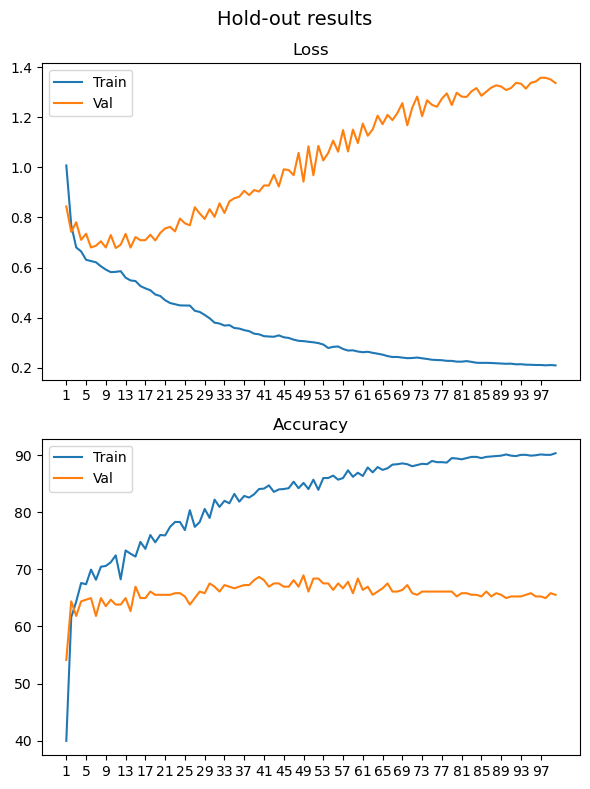

In [41]:
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")

fig.tight_layout()

#### K-FOLD

In [282]:
EPOCHS = 100
n_losses, n_accuracies = train_test.kfold_train_model(
    X_train_val.values,
    y_train_val.values,
    N_SPLITS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    print_every=5,
    ce_weights=weights,
    reduce_lr=True,
    max_accuracy=70
)

for i, acc in enumerate(n_accuracies):
    max_i, max_acc = np.argmax(acc["val"]), np.max(acc["val"])
    print(f"Fold {i+1}: Max accuracy {max_acc:.2f} at epoch {max_i}")


Epoch 005: | Loss: 0.64418 | Acc: 68.661 | Val loss: 0.74287 | Acc: 64.387
Epoch 010: | Loss: 0.57704 | Acc: 70.584 | Val loss: 0.71382 | Acc: 64.672
Epoch 015: | Loss: 0.52652 | Acc: 74.145 | Val loss: 0.72382 | Acc: 65.242
Epoch 020: | Loss: 0.47673 | Acc: 73.433 | Val loss: 0.77450 | Acc: 69.231
Epoch 025: | Loss: 0.41531 | Acc: 79.843 | Val loss: 0.78770 | Acc: 66.667
Epoch 030: | Loss: 0.36736 | Acc: 82.194 | Val loss: 0.88043 | Acc: 63.818
Epoch 035: | Loss: 0.33178 | Acc: 83.333 | Val loss: 0.92241 | Acc: 66.097
Epoch 00038: reducing learning rate of group 0 to 5.0000e-03.
Epoch 040: | Loss: 0.28613 | Acc: 86.111 | Val loss: 1.00892 | Acc: 67.806
Epoch 045: | Loss: 0.26058 | Acc: 87.607 | Val loss: 1.04276 | Acc: 66.667
Epoch 050: | Loss: 0.26102 | Acc: 86.396 | Val loss: 1.11574 | Acc: 68.091
Epoch 00054: reducing learning rate of group 0 to 2.5000e-03.
Epoch 055: | Loss: 0.23361 | Acc: 88.675 | Val loss: 1.16336 | Acc: 66.952
Epoch 060: | Loss: 0.21616 | Acc: 90.456 | Val loss

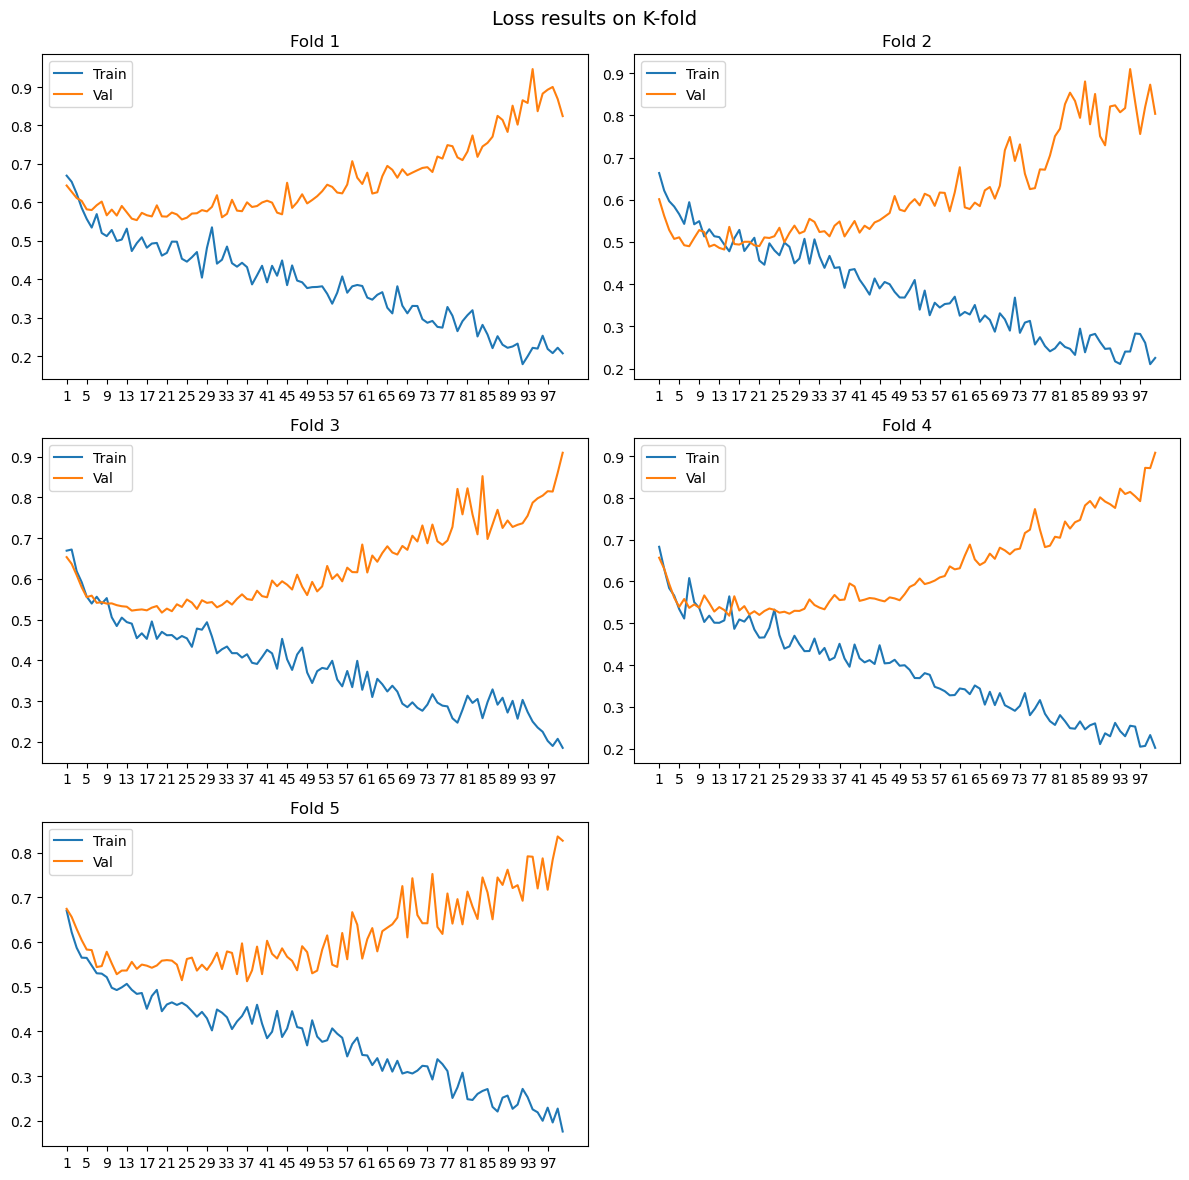

In [211]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.tight_layout()

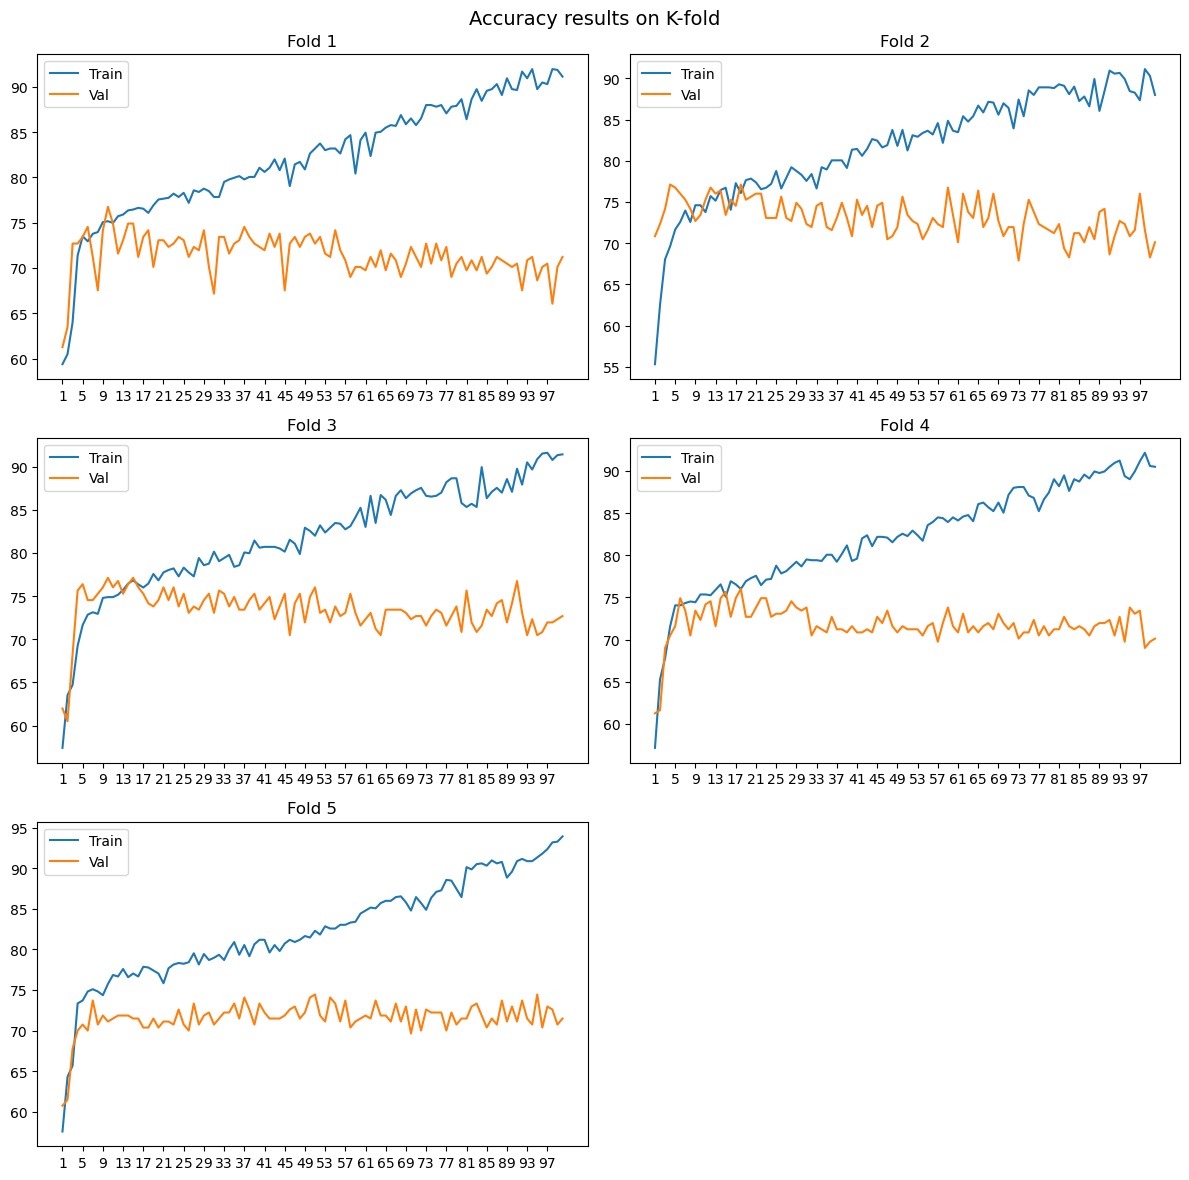

In [213]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

plt.tight_layout()

#### Test the model

In [42]:
y_pred = train_test.test_model(X_test.values, 64)

count_labels, name_labels = [0,1, 2], ["low", "medium", "medium-high"]
print(classification_report(y_test, y_pred, labels=count_labels, target_names=name_labels))

              precision    recall  f1-score   support

         low       0.70      0.78      0.74       156
      medium       0.71      0.64      0.67       207
 medium-high       0.66      0.68      0.67        77

    accuracy                           0.70       440
   macro avg       0.69      0.70      0.69       440
weighted avg       0.70      0.70      0.69       440



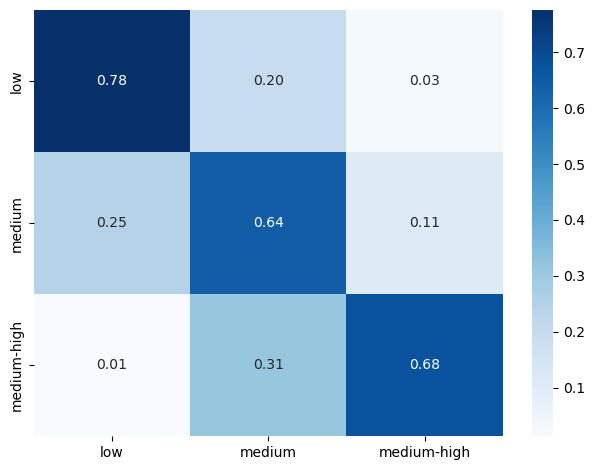

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [19]:
from sklearn.metrics import balanced_accuracy_score

In [44]:
balanced_accuracy_score(y_test, y_pred)

0.6978259260867956

In [45]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


accuracy = evaluate_predictions(y_test, y_pred)
print(f"Accuracy on test: {accuracy:.3f}")

Accuracy on test: 69.545


## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT

In [22]:
from utils import util_counterfactual

In [23]:
def evaluate_sample(model, sample_idx):
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        sample_idx = torch.tensor(sample_idx, dtype=torch.float).view(1, -1).to(device)

        # inference and print logits
        y_logit = model(sample_idx)
        print(f"Logits: {y_logit.squeeze()}")
        
        # compute softmax
        y_prob = torch.softmax(y_logit, dim=1)
        print(f"Softmax: {y_prob.squeeze()}")

        # print softmax of predicted class
        y_pred = torch.argmax(y_prob, dim=1)
        print(f"Predicted class {y_pred.item()} with probability: {y_prob.squeeze()[y_pred].item():.3f} and logit: {y_logit.squeeze()[y_pred].item():.3f}")

        # marginlal softmax
        marginal_softmax = torch.log(torch.sum(torch.exp(y_logit))) - y_logit.squeeze()[y_pred].item()
        print(f"Marginal softmax: {marginal_softmax:.3f}\n")

    return y_pred.item()

A marginal softmax computation is performed to compute the probability of the target class with log-linear complexity. However, instead of giving a probability distribution over the target class, it is more similar to a loss, which is minimized.

The minimum value of the marginal softmax for misclassified samples is approximately 0.70, thus a threshold of 0.70 or lower is used to find the counterfactuals.

Number of samples 1404
Minimum value of misclassified samples: 0.696


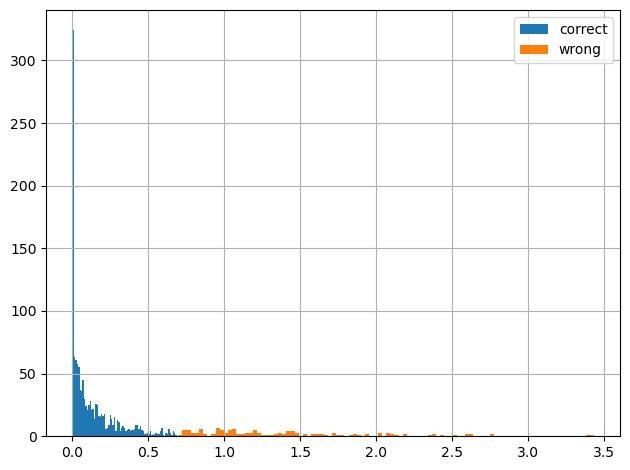

In [24]:
def difference_log_softmax(model, X, y, device):
    print(f"Number of samples {X.shape[0]}")
    model.eval()
    with torch.no_grad():
        correct_diff = []
        wrong_diff = []
        for i in range(X.shape[0]):
            X_i = torch.tensor(X[i], dtype=torch.float).view(1, -1).to(device)
            y_i = round(y[i])

            output = model(X_i)
            y_prob = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_prob, dim=1).item()

            marginal_softmax = torch.log(torch.sum(torch.exp(output))) - output.squeeze()[y_i].item()

            if y_pred == y_i:
                correct_diff.append(marginal_softmax)
            else:
                wrong_diff.append(marginal_softmax)


    return np.array(correct_diff), np.array(wrong_diff)

# compute marginal softmax
correct_diff, wrong_diff = difference_log_softmax(nn_model, X_train.values, y_train.values, device)
print(f"Minimum value of misclassified samples: {np.min(wrong_diff):.3f}")

# plot histogram
pd.Series(correct_diff).hist(bins=100, label="correct")
pd.Series(wrong_diff).hist(bins=100, label="wrong")
plt.legend()
plt.tight_layout()

Sample of the test set of which we want to find the counterfactuals.

In [25]:
idx = 17
sample_idx = X_test.values[idx]
label_idx = y_test.values[idx]
predict_idx = evaluate_sample(nn_model, sample_idx)

cf_class = util_counterfactual.get_counterfactual_class(label_idx, num_class, lower=True)
print(f"Ground-truth label: {label_idx}")
print(f"Predicted label: {predict_idx}. It is {str(label_idx == predict_idx).upper()} that the ground-truth label is the same as the predicted label")

if not label_idx == predict_idx:
    raise ValueError("The ground-truth label is not the same as the predicted label")

print(f"Counterfactual label: {cf_class}", end="\n\n")

Logits: tensor([-19.9612,  -0.7179,   3.9981])
Softmax: tensor([3.8972e-11, 8.8714e-03, 9.9113e-01])
Predicted class 2 with probability: 0.991 and logit: 3.998
Marginal softmax: 0.009

Ground-truth label: 2.0
Predicted label: 2. It is TRUE that the ground-truth label is the same as the predicted label
Counterfactual label: 1



In [26]:
cplex_path = os.path.join("C:\Program Files", "IBM", "ILOG", "CPLEX_Studio221", "cplex", "bin", "x64_win64", "cplex.exe")
ipopt_path = os.path.join("C:\\Users", os.getlogin(), "ipopt", "bin", "ipopt.exe")

In [27]:
continuous_feat = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
solver_options = {"timelimit": 120}

omlt_count = util_counterfactual.OmltCounterfactual(X_train, y_train, nn_model, continuous_feat=continuous_feat)

In [28]:
min_probability = 0.5
cf = omlt_count.generate_counterfactuals(sample_idx, 
                                         cf_class, 
                                         min_probability, 
                                         obj_weights=[1, 0.5, 0.8], 
                                         solver_options=solver_options,
                                         verbose=True)

Starting MindtPy version 0.1.0 using OA algorithm
iteration_limit: 50
stalling_limit: 15
time_limit: 60
strategy: OA
add_regularization: None
call_after_main_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x0000015A6F6A2940>
call_after_subproblem_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x0000015A6F6A2850>
call_after_subproblem_feasible: <pyomo.contrib.gdpopt.util._DoNothing object at 0x0000015A6F6A2880>
tee: true
logger: <Logger pyomo.contrib.mindtpy (INFO)>
logging_level: 20
integer_to_binary: false
add_no_good_cuts: false
use_tabu_list: false
single_tree: false
solution_pool: false
num_solution_iteration: 5
cycling_check: true
feasibility_norm: L_infinity
differentiate_mode: reverse_symbolic
use_mcpp: false
calculate_dual_at_solution: false
use_fbbt: false
use_dual_bound: true
partition_obj_nonlinear_terms: true
quadratic_strategy: 0
move_objective: false
add_cuts_at_incumbent: false
heuristic_nonconvex: false
init_strategy: rNLP
level_coef: 0.5
solution_limit:

In [78]:
from pyomo.core.base.objective import ScalarObjective
from pyomo.core.base.var import ScalarVar, IndexedVar
from pyomo.core.expr.numeric_expr import DivisionExpression
import pyomo.environ as pyo


def same_softmax(input, n_class):
    exps = [pyo.exp(input[i].value) for i in range(n_class)]
    probs = []
    for exp in exps:
        res = exp/sum(exps)
        probs.append(res)
    return probs

obj_value = omlt_count.pyo_model.obj
# q_relu = omlt_count.pyo_model.obj1_q_relu
# diff_prob = omlt_count.pyo_model.obj1_diff_prob
nn_outputs = omlt_count.pyo_model.nn.outputs
# max_value = omlt_count.pyo_model.obj1_max_val
# softmax_outputs = same_softmax(nn_outputs, n_class=num_class)

isinstance(obj_value, ScalarObjective)
# isinstance(q_relu, ScalarVar)
# isinstance(diff_prob, ScalarVar)
# isinstance(max_value, ScalarVar)
isinstance(nn_outputs, IndexedVar)
# isinstance(softmax_outputs, DivisionExpression)

from pyomo.core.base import value

print(f"Objective value: {value(obj_value)}", end="\n\n")
# print(f"q_relu value: {value(q_relu)}", end="\n\n")
# print(f"diff_prob value: {value(diff_prob)}", end="\n\n")
# print(f"max_value value: {value(max_value)}", end="\n\n")

for i in range(len(nn_outputs)):
    print(f"nn_outputs value {i}: {value(nn_outputs[i])}")
    # print(f"softmax_outputs {i}: {softmax_outputs[i]}")

Objective value: 6.407263648196863

nn_outputs value 0: -2.4554529718146445
nn_outputs value 1: 0.44308307305658956
nn_outputs value 2: -0.07843714101639865


In [71]:
omlt_count.pyo_model.pprint()

1 Set Declarations
    b_o3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   18 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

2 Param Declarations
    obj1_big_m_lb_relu : Size=1, Index=None, Domain=Any, Default=0, Mutable=False
        Key : Value
    obj1_big_m_ub_relu : Size=1, Index=None, Domain=Any, Default=10, Mutable=False
        Key : Value

7 Var Declarations
    b_o3 : Size=18, Index=b_o3_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   1.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
     

In [30]:
print("--Sample output--")
y_pred_orig = evaluate_sample(nn_model, sample_idx)

print("--Counterfactual sample--")
counter_idx = cf.loc[0, :].values
y_pred_count = evaluate_sample(nn_model, counter_idx)

if cf_class != y_pred_count:
    raise ValueError("The counterfactual sample did not change the label of the original sample")

print(f"The predicted class for the original sample is {y_pred_orig}, while the predicted sample for the counterfactual is {y_pred_count}.")
print(f"The counterfactual sample {'DID' if (cf_class == y_pred_count) else 'DID NOT'} change the label of the original sample.")

--Sample output--
Logits: tensor([-19.9612,  -0.7179,   3.9981])
Softmax: tensor([3.8972e-11, 8.8714e-03, 9.9113e-01])
Predicted class 2 with probability: 0.991 and logit: 3.998
Marginal softmax: 0.009

--Counterfactual sample--
Logits: tensor([-11.5706,   0.8505,   0.4177])
Softmax: tensor([2.4458e-06, 6.0653e-01, 3.9347e-01])
Predicted class 1 with probability: 0.607 and logit: 0.850
Marginal softmax: 0.500

The predicted class for the original sample is 2, while the predicted sample for the counterfactual is 1.
The counterfactual sample DID change the label of the original sample.


#### Convert the results with scikit-learn transformers

In [31]:
new_sample = pd.DataFrame(np.array(counter_idx, ndmin=2), columns=X_train_val.columns, index=["Counterfactual"])
orig_sample = pd.DataFrame(sample_idx.reshape(1, -1), columns=X_train_val.columns, index=["Orig sample"])
features_df = pd.concat([new_sample, orig_sample], axis=0)

label_df = pd.Series([cf_class, label_idx], name="misc_price", index=features_df.index).to_frame()
comp_df = pd.concat([features_df, label_df], axis=1)

In [32]:
comp_df

,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution,misc_price
Counterfactual,0.999997,0.999987,0.802435,-0.104819,0.999995,0.977899,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
Orig sample,2.410179,2.068216,0.802435,1.545659,1.850258,2.083888,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0


In [33]:
def display_transformer(df: pd.DataFrame, df_res: pd.DataFrame, ord=2) -> pd.DataFrame:
    def compute_distance(x, y):
        return np.argmin(np.linalg.norm(x - y, ord=ord, axis=1))

    series_transform = df.apply(lambda x: df_res.index[compute_distance(x, df_res)], axis=1)
    df_transform = pd.DataFrame(series_transform, columns=["display_resolution"])
    assert isinstance(df_transform, pd.DataFrame)
    return df_transform

cols_pipeline = pickle.load(open("config/pipeline_stdscaler.pkl", "rb"))

In [34]:
def get_bin_edges(label: float):
    label = int(label)
    return pd.Series(cols_pipeline.transformers_[0][1][2].bin_edges_.item()[label: label+2], index=["price_min", "price_max"])


def inverse_pipeline(cols_pipeline, samples):
    results = pd.DataFrame()

    for name, p, cols in cols_pipeline.transformers_:
        if name == "pipeline-1":
            bin_edges = samples.misc_price.apply(get_bin_edges)
            exp_edges = p[1].inverse_transform(bin_edges)
            results = pd.concat([results, exp_edges], axis=1)

        elif name == "pipeline-2":
            quantile_inv = p[0].inverse_transform(samples[cols])
            quantile_df = pd.DataFrame(quantile_inv, columns=cols, index=samples.index)
            results = pd.concat([results, quantile_df], axis=1)

        elif name == "pipeline-3":
            results = pd.concat([results, samples[cols]], axis=1)

        elif name == "pipeline-4":
            ordinal_inv = p[0].inverse_transform(samples[cols])
            ordinal_df = pd.DataFrame(ordinal_inv, columns=cols, index=samples.index)
            results = pd.concat([results, ordinal_df], axis=1)

        elif name == "pipeline-5":
            cols = p[1].feature_names_in_
            ordinal_inv = p[1].inverse_transform(samples[cols])
            ordinal_df = pd.DataFrame(ordinal_inv, columns=cols, index=samples.index)
            results = pd.concat([results, ordinal_df], axis=1)

    return results


inverse_pipeline(cols_pipeline, comp_df)

,price_min,price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
Counterfactual,184.060285,375.632818,6.245541,4060.390482,6.0,40.560547,28.903543,15.713436,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4G,2.0,1.0,HD
Orig sample,375.632818,1500.000000,7.200000,5000.000000,6.0,128.000000,40.000000,24.000000,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4G,3.0,1.0,FHD


#### PCA of features

<Axes: xlabel='PC1', ylabel='PC2'>

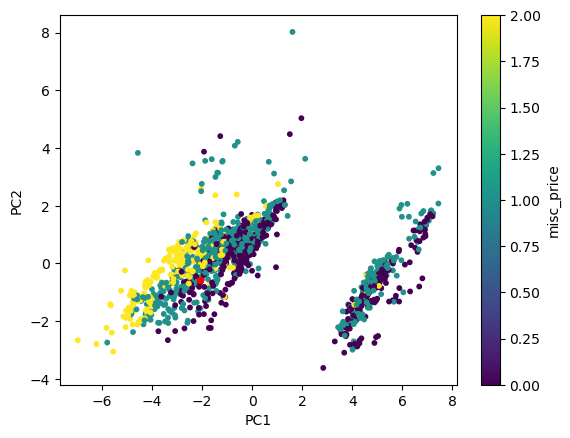

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

train_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"], index=X_train.index)
train_pca["misc_price"] = y_train

fig, axs = plt.subplots()
train_pca.plot.scatter(x="PC1", y="PC2", c="misc_price", colormap="viridis", ax=axs, s=10)

X_new_sample_pca = pca.transform(new_sample)
new_sample_pca = pd.DataFrame(X_new_sample_pca, columns=["PC1", "PC2"], index=new_sample.index)
new_sample_pca.plot.scatter(x="PC1", y="PC2", c="red", s=20, ax=axs)

In [129]:
same_label_train.iloc[0, :]

PC1           6.603996
PC2           0.739830
misc_price    1.000000
Name: 199, dtype: float64

In [132]:
new_sample_pca

,PC1,PC2
Counterfactual,-2.096052,-0.58046


In [133]:
def compute_distance(x, y):
    return np.linalg.norm(x - y, ord=2, axis=1)

same_label_train = train_pca[train_pca.misc_price == cf_class]
counterfactual_distance = same_label_train.apply(lambda x: compute_distance(x[["PC1", "PC2"]], new_sample_pca), axis=1)
counterfactual_distance = counterfactual_distance.sort_values()

min_index = counterfactual_distance.index[0]
closer_sample = X_train_val.loc[min_index]

# closer_sample
print(f"Distance to the closest sample: {counterfactual_distance.iloc[0]}\n")
print(f"Price of the closest sample: {y_train.loc[min_index]}\n")
print(f"Features of the closest sample:\n{closer_sample}")

Distance to the closest sample: [0.05524922]

Price of the closest sample: 1.0

Features of the closest sample:
display_size                0.824933
battery                     0.817902
memory_ram_gb               0.616541
memory_rom_gb               0.716839
main_camera_resolution     -0.443149
selfie_camera_resolution    0.360172
has_oled_display            0.000000
has_memory_card_slot        1.000000
has_stereo_speakers         0.000000
has_3.5mm_jack              1.000000
has_wlan_5ghz               1.000000
has_nfc                     0.000000
has_wireless_charging       0.000000
is_waterproof               0.000000
network_technology          1.000000
num_main_camera             2.000000
num_selfie_camera           0.000000
display_resolution          2.000000
Name: 1559, dtype: float64


In [134]:
df_closer_sample = pd.DataFrame(closer_sample.to_numpy().reshape(1, -1), columns=X_train_val.columns, index=["Closer sample"])
features_df = pd.concat([new_sample, df_closer_sample], axis=0)

label_df = pd.Series([cf_class, y_train.loc[min_index]], name="misc_price", index=features_df.index).to_frame()
comp_df = pd.concat([features_df, label_df], axis=1)

inverse_pipeline(cols_pipeline, comp_df)


,price_min,price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
Counterfactual,184.060285,375.632818,6.39,4000.0,4.0,32.0,16.0,16.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4G,2.0,1.0,HD
Closer sample,184.060285,375.632818,6.26,4000.0,4.0,64.0,12.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4G,3.0,1.0,FHD


### Dice

In [ ]:
from utils.util_counterfactual import DiceCounterfactual

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [ ]:
df_dice = pd.concat([X_train_val, y_train_val], axis=1)
df_dice.head()

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera,misc_price
1544,0.0,1.0,0.0,-0.369077,-0.486427,1.906789,1.449594,-0.422592,0.186784,-0.347239,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
876,0.0,1.0,0.0,0.839438,-0.118456,0.500206,0.653849,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1339,0.0,1.0,0.0,0.873967,0.776940,-0.906378,-0.619344,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0
1424,0.0,1.0,0.0,-0.455400,-0.486427,-0.906378,-0.778493,0.159890,0.186784,-0.417016,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
287,0.0,1.0,0.0,-0.455400,-0.977055,-0.906378,-0.778493,-0.713833,-0.791101,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


We initialize an instance of the class we created for dealing with Dice and generating counterfactuals.

In [ ]:
cont_features = list(df_dice.columns)
cont_features.remove('misc_price')

dice_cf = DiceCounterfactual(lgb_model.model, 'sklearn', df_dice, cont_features, target="misc_price")

In the first example we only choose one sample, that originally has label 3 (high price) and we want to produce a counterfactual that has label 2 to check which features we can change to decrease the price.

In [ ]:
idx = 40
count_class = 2

orig_sample = df_dice.iloc[[idx]]
orig_sample_lab = df_dice.iloc[[idx]]['misc_price']

We will use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [ ]:
dice_cf.create_explanation_instance(method="genetic")

cfs = dice_cf.generate_counterfactuals(orig_sample, new_class=count_class, target="misc_price", n_cf=2)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


We standardize the original samples and the counterfactuals to get real values for the devices.

In [ ]:
pairs = dice_cf.destandardize_cfs_orig(scaler_num=std_transf)

After that we got the sample - counterfactuals pairs we can pass them to a function in order to compare the differences in the features that allow to classify the sample as the desired class.

In [ ]:
compare_dfs = dice_cf.compare_sample_cf(pairs, color="red")

At the end we can print the comparison for all the samples for which we generated the counterfactuals simply retrieving the dataframe from the list.

In [ ]:
compare_dfs[0]

,Original sample,Counterfactual_0,Counterfactual_1
network_technology_3G,0.000,0.000,0.000
network_technology_4G,1.000,1.000,1.000
network_technology_5G,0.000,0.000,0.000
display_size,6.500,5.500,5.500
battery,3330.000,2730.000,3100.000
display_width,1644.000,1440.000,1440.000
display_height,3840.000,2560.000,960.000
memory_rom_gb,64.000,64.000,64.000
memory_ram_gb,6.000,6.000,6.000
main_camera_resolution,12.000,12.000,12.000


TODO
We can explore different interesting parameters in Dice:
- in 'generate_counterfactuals' function we can use:
    - proximity_weight, diversity_weight;
    - permitted_range, a dictionary with the feature names as keys and a list of the allowed values;
    - features_to_vary;